## Bet Against the Beta

The idea is to use CAPM to find individual stock's current monthly end beta, at start of next month, 

open long position for stocks that have low beta and open short position for stocks with high beta.

But is that also work in HK market?

To calculate the risk free rate, I use 1 month hibor fixing rate data from HKMA API.


In [1]:
import pandas as pd
import numpy as np 
import os
import yfinance as yf
import requests
import datetime
import time
import matplotlib.pyplot as plt
import sys
import warnings
warnings.simplefilter('ignore')


# start_date= "2005-01-01"
# end_date= "2024-06-30"

# start_date_dt=datetime.datetime.strptime(start_date,'%Y-%m-%d')
# end_date_dt=datetime.datetime.strptime(end_date,'%Y-%m-%d')

# curr_start_date_dt=start_date_dt
# curr_end_date_dt=curr_start_date_dt +datetime.timedelta(days=120)

# data_list=[]
# while curr_start_date_dt <= end_date_dt:
#     if curr_start_date_dt + datetime.timedelta(days=120)>end_date_dt:
#         curr_end_date_dt=end_date_dt

#     curr_start_date_str=curr_start_date_dt.strftime('%Y-%m-%d')
#     curr_end_date_str= curr_end_date_dt.strftime('%Y-%m-%d')

#     curr_start_date_dt+=datetime.timedelta(days=120)
#     curr_end_date_dt+=datetime.timedelta(days=120)

#     url="https://api.hkma.gov.hk/public/market-data-and-statistics/daily-monetary-statistics/daily-figures-interbank-liquidity"
#     url+="?choose=end_of_date&from=" +curr_start_date_str+ "&to=" +curr_end_date_str

#     response=requests.get(url)
#     data=response.json()
#     data=pd.json_normalize(data['result']['records'])
#     data_list.append(data)
#     time.sleep(1)
    
# data=pd.concat(data_list)
# data.to_csv("C:/Users/Attila/Desktop/hibor.csv")    
# data['Date']=pd.to_datetime(data["end_of_date"])
# data.set_index('Date',inplace=True)
# data=data.drop_duplicates(subset="end_of_date",keep='last')
# data=data.sort_index()
# # data=data["hibor_fixing_1m"].copy()
data = pd.read_csv("C:/Users/Attila/Desktop/hibor.csv")
data['Date'] = pd.to_datetime(data["end_of_date"])
data.set_index('Date',inplace=True)
data = data.drop_duplicates(subset="end_of_date",keep='last')
data = data.sort_index()

For HK stocks, I manually selected some HK stocks that have good volume and turnover

In [2]:
import pandas as pd
import numpy as np 
import os
import yfinance as yf
import requests
import datetime
import time
import matplotlib.pyplot as plt
import sys
tickers = ["0700.HK","9988.HK","3690.HK","0939.HK","1398.HK","0005.HK","0941.HK","0883.HK",
           "1299.HK","2318.HK","9618.HK","0388.HK","1211.HK","1810.HK","1024.HK","0992.HK",
           "1088.HK","2628.HK"]
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2024-06-30')

        df.to_csv(file_name)

    df = pd.read_csv(file_name)
    df["Date"] = df["Date"].astype("string")
    df["Date"] = df["Date"].str[:10]
    df['Date'] = pd.to_datetime(df["Date"])
    df.set_axis(df["Date"],inplace=True)
    df['risk_free_rate']=data["hibor_fixing_1m"]
    df = df.resample('M').agg({
        "Open":'first',
        "Close":"last",
        'risk_free_rate':"last"
    })
    df['this_month_return'] = (df["Close"]-df["Open"])/df["Open"]
    df["next_month_return"] = df['this_month_return'].shift(-1)
    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

        
hsi = load_data("^HSI")
tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

Loaded data for 18 companies


In [14]:

trade=pd.DataFrame()
beta_high = 1.5
beta_low = 0.6
return_long = 0
return_short = 0
for stock in holder:
    stock["market_return"] = hsi['this_month_return']
    stock['monthly_beta'] = (stock["this_month_return"] - stock['risk_free_rate']) / (stock["market_return"] - stock['risk_free_rate'])
    stock['position'] = 0
    stock.loc[stock['monthly_beta'] <= beta_low,'position'] = 1
    stock.loc[stock['monthly_beta'] >= beta_high,'position'] = -1
    stock["strategy_return"]=stock['position'] * stock['next_month_return']
    trade=pd.concat([trade,stock])
trade=trade.groupby(trade.index).sum()


Sharpe Ratio is : -0.11416235271638306
Cumulative Return is 6.355589545459166


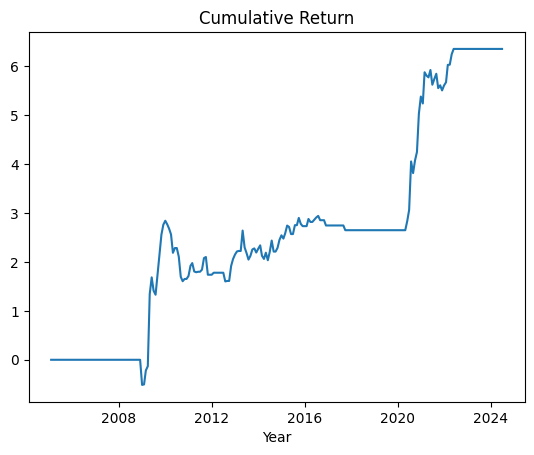

In [15]:
cum_return=trade['strategy_return'].cumsum()
plt.plot(cum_return)
plt.title("Cumulative Return")
plt.xlabel("Year")
sharpe=stock["strategy_return"].mean() / stock["strategy_return"].std() * np.sqrt(252)
print(f'Sharpe Ratio is : {sharpe}')
print(f'Cumulative Return is {cum_return[-1]}')


| Long stock if beta is lower than | Shortsell stock if beta is higher than | Cumulative Return | Sharpe Ratio |
|:---------|:--------:|---------:|---------:|
| 0.5  |  1.5   | 541.08%  |  0.71 |
|  0.5   |  1.4   |  492.63%   | 0.60 |
|  0.5   |  1.3   |  466.60%   | 0.30  |
||||
|  0.2   |  1.5   |  257.04%   | 0.67  |
|  0.3  |  1.5   |  314.78%   | 0.66  |
|  0.4   |  1.5   |  388.07%   | 1.46  |
|  0.6  |  1.5   |  635.56%   | -0.11  |